In [15]:
%autosave 60

Autosaving every 60 seconds


Kramer versus Kramer
---------------------------

Explain this

In [1]:
# random
from random import random

# math functions
from math import cos, sin, atan2
from math import radians

# load MDAnalysis library 
# to deal with GRO/XTC files
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.dihedrals import Dihedral
from MDAnalysis.analysis.dihedrals import Ramachandran

# arrays
import numpy as np

# machine learning
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

# plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Molecular Dynamics in *Anton 2*
--------------------------------------

Load trajectory files. Describe them. Form of the restrain!

In [2]:
# define path to structure files
PATHD = "../datasets/trajectories/"
FRAME = PATHD + "CLCec1_anton2_restrained_15us.gro"
TRAJ1 = PATHD + "CLCec1_anton2_restrained_15us.xtc"
TRAJ2 = PATHD + "CLCec1_anton2_unrestrain_15us.xtc"

# load traj files
rest = mda.Universe(FRAME,TRAJ1)
unrs = mda.Universe(FRAME,TRAJ2)

OSError: File does not exist: b'../datasets/trajectories/CLCec1_anton2_restrained_15us.xtc'

 I will avoid fitting (rot+trans) for now

In [ ]:
# fitting
#ref = mda.Universe(FRAME)
#fit = align.AlignTraj(trj, ref, select="protein and name CA", in_memory=True)
#fit.run()

Ramachandran analysis
----------------------------

Let's compare both trajectories using a simple dihedral analysis, no fitting requiered

In [ ]:
# select protein residues
restrained = rest.select_atoms("protein and resid 2-429")
unrestrain = unrs.select_atoms("protein and resid 2-429")

# quick calculation of phi and psi angles
R = Ramachandran(restrained).run()
U = Ramachandran(unrestrain).run()

plotting. 

1) get a reference using RESTful

2) use a better plotting program

In [ ]:
# create a figure and three subplots
fig, axes = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(18,6))

# axes decoration
for ax in axes:
    ax.axis([-180,180,-180,180])
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
           xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")

# set titles    
axes[0].title.set_text('Restrained')
axes[1].title.set_text('Unrestrained')
axes[2].title.set_text('Reference')
    
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# plot backbone dihedral maps for all frames
axes[0].hist2d(r[:,0], r[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)
axes[1].hist2d(u[:,0], u[:,1], bins=100, range=[[-180,180],[-180,180]], norm=LogNorm(), cmap=plt.cm.Blues)

# plot reference map which shows allowed and marginally allowed regions
U.plot(ax=axes[2], color='k', marker=".", alpha=0.0, ref=True)

plt.show()

<center>the <i>Unrestrained</i> is more flexible, as expected, but also more similar to the <i>Reference</i> map.
At least for me, in a qualitative way.</center>

dPCA+
--------

Let's compare the 2 trajectories! Principal Component Analysis of dihedral angles
Implementation of the dPCA+ method from references:
     
J Comput Chem. 2009; 30(3):479-92. doi: 10.1002/jcc.21076.

J Chem Phys. 2017; 147(24):244101. doi: 10.1063/1.4998259.

In [ ]:
# reshape angle arrays
r = R.angles.reshape(np.prod(R.angles.shape[:2]), 2)
u = U.angles.reshape(np.prod(U.angles.shape[:2]), 2)

# convert to radians
ress = np.deg2rad(r)
unre = np.deg2rad(u)

# combine datasets
data = np.vstack((ress,unre))

In [ ]:
from __classes import dPCAplus

In [ ]:
# create object
pippo = dPCAplus(data, 600)

# save dataset
pippo.save("../datasets/MD_datasets.csv")

# run pca
pca, vec = pippo.dopca()

Plot

NameError: name 'pca' is not defined

Exception ignored in: <function ReaderBase.__del__ at 0x111011730>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/base.py", line 2105, in __del__
    self.close()
  File "/anaconda3/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py", line 172, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


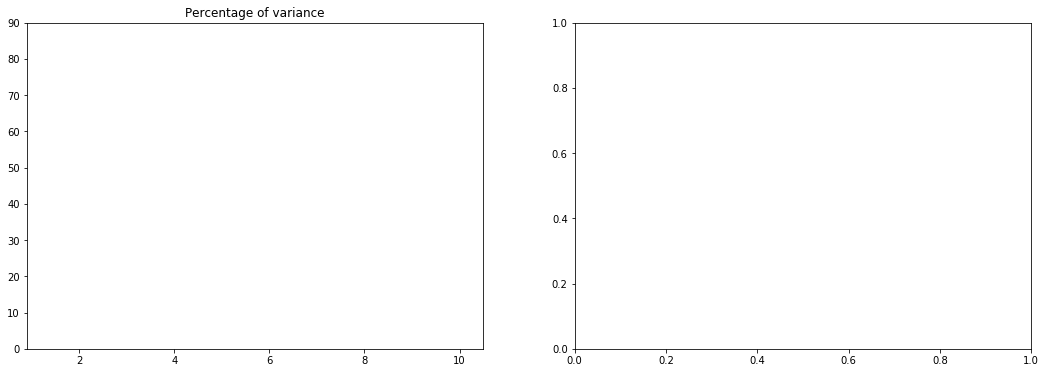

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.axis([0.9,10.5,0,90])
ax1.title.set_text('Percentage of variance')
#ax1.set(yticks=range(0, 21, 5), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax1.plot(range(1,11), pca.explained_variance_ratio_[:10]*100, marker='.', linestyle='dashed')

#ax2.axis([-15,15,-8,8])
ax2.title.set_text('PCA')
#ax2.set(xticks=range(-12, 13, 4), xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
ax2.scatter(vec[:300,0], vec[:300,1], color='blue',  alpha=.8, label='traj1')
ax2.scatter(vec[300:,0], vec[300:,1], color='green', alpha=.8, label='traj2')

Analysis PCA / Cross validation score